In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [2]:
# 1. load data
# 2. preprocessing data -> dataset
# 3. tools
#    3.1 generates position embedding
#    3.2 create mask. (a.padding, b.decoder)
#    3.3 scaled_dot_product_attention
# 4. builds model
#    4.1 MultiheadAttention
#    4.2 EncoderLayer
#    4.3 DecoderLayer
#    4.4 EncoderModel
#    4.5 DecoderModel
#    4.6 Transformer
# 5. optimizer & loss
# 6. train step -> train
# 7. Evaluate and Visualize

In [3]:
# 1. load data
import tensorflow_datasets as tfds

examples, info = tfds.load('ted_hrlr_translate/pt_to_en', with_info = True, as_supervised = True)

train_examples, val_examples = examples['train'], examples['validation']
print(info)

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)



In [4]:
for pt,en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print()

b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'

b'mas e se estes fatores fossem ativos ?'
b'but what if it were active ?'

b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .'
b"but they did n't test for curiosity ."

b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .'
b'and this conscious defiance is why i , as an agnostic , can still have faith .'

b"`` `` '' podem usar tudo sobre a mesa no meu corpo . ''"
b'you can use everything on the table on me .'



In [5]:
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt,en in train_examples),target_vocab_size=2 **13)
pt_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt,en in train_examples),target_vocab_size=2 **13)


In [6]:
#简单看看句子tokenized的效果
sample_string = 'Transformer is awesome.'
tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

origin_string = en_tokenizer.decode(tokenized_string)
print(('The original string is {}'.format(origin_string)))

assert origin_string == sample_string

for token in tokenized_string:
    print('{} --> "{}"'.format(token, en_tokenizer.decode([token])))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string is Transformer is awesome.
7915 --> "T"
1248 --> "ran"
7946 --> "s"
7194 --> "former "
13 --> "is "
2799 --> "awesome"
7877 --> "."


In [7]:
#数据预处理
buffer_size = 20000
batch_size = 64
max_length = 40

# tokenize the sentence
def encode_to_subword(pt_sentence, en_sentence):
    pt_sequence = [pt_tokenizer.vocab_size] + pt_tokenizer.encode(pt_sentence.numpy()) + [pt_tokenizer.vocab_size +1]
    en_sequence = [en_tokenizer.vocab_size] + en_tokenizer.encode(en_sentence.numpy()) + [en_tokenizer.vocab_size +1]
    return pt_sequence,en_sequence

#将长度大于40的句子过滤掉  返回布尔型
def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt)<= max_length, tf.size(en)<= max_length)

#将python函数封装起来
def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword, [pt_sentence,en_sentence], [tf.int64, tf.int64])

train_dataset = train_examples.map(tf_encode_to_subword)  #将数据集从word变成数字
train_dataset = train_dataset.filter(filter_by_max_length)  #过滤长度
train_dataset = train_dataset.shuffle(buffer_size).padded_batch(batch_size, padded_shapes=([-1],[-1]))  #shuffle and padding ,padding到每个维度上的最大数值

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(filter_by_max_length)
valid_dataset = valid_dataset.shuffle(buffer_size).padded_batch(batch_size, padded_shapes=([-1],[-1]))

In [8]:
for pt_batch, en_batch in valid_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

(64, 38) (64, 39)
(64, 39) (64, 34)
(64, 40) (64, 36)
(64, 36) (64, 40)
(64, 40) (64, 40)


In [9]:
#3.1 生成位置编码
# PE(pos,2i) = sin(pos/10000^(2i/d_model))
# PE(pos,2i+1) = cos(pos/10000^(2i/d_model))  #pos词语在句子中的位置， i：在embedding中的位置，d_model是embedding的大小，i有d_model个位置

#首先完成sin cos里面的那一部分
#pos.shape:(senten_length,1)
#i.shape:(1,d_model)
#result.shape:(sentence_length, d_model)
def get_angles(pos, i, d_model):
    angel_rates = 1/np.power(10000, (2*(i//2))/np.float32(d_model))
    return pos*angel_rates

def get_positional_embedding(sentence_length, d_model):
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis], np.arange(d_model)[np.newaxis, :],d_model)
    #sines.shape:(sentence_length, d_model/2)
    #cosines.shape:(sentence_length, d_model/2)
    sines = np.sin(angle_rads[:,0::2])
    cosines = np.cos(angle_rads[:,1::2])
    #position_embedding.shape: (sentence_length, d_model)
    position_embedding = np.concatenate([sines,cosines],axis=-1)
    # position_embedding.shape: [1, sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ...]  #扩展一个维度，以后可以做batch
    return tf.cast(position_embedding,dtype=tf.float32)

position_embedding = get_positional_embedding(50, 512)
print(position_embedding.shape)

(1, 50, 512)


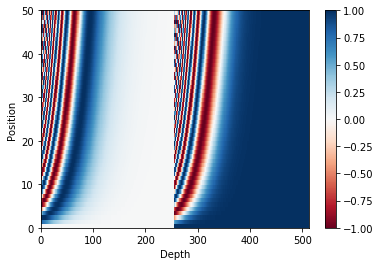

In [10]:
#把position_embedding画出来
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0],cmap='RdBu')
    plt.xlabel('Depth')
    plt.xlim((0,512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()

plot_position_embedding(position_embedding)

In [11]:
#3.2 生成mask 1.padding mask, 2.decode look ahead mask 不能和之后的词语进行attention

#batch_data.shape: (batch_size, seq_len) （64.40）
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data,0),tf.float32)
    return padding_mask[:,tf.newaxis, tf.newaxis,:]   #为了使这个和attention_weights更方便计算而reshape
#padding_shape:(batch_size,1,1,seq_len)

x = tf.constant([[7,6,0,0,1],[1,2,3,0,0],[0,0,0,4,5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [12]:
#假设attention_weights.shape:[3,3]
#{{1,2,3],[4,5,6],[7,8,9]]  1:第一个单词跟第一个单词自己的attention，2：第一个单词跟第二个单词的attention， 4：第二个单词和第一个单词的attention
#如果要前词看不见后词，就需要：[{1,0,0],[4,5,0],[7,8,9]]
def create_look_ahead_mask(size):
    mask = 1-tf.linalg.band_part(tf.ones((size,size)),-1,0)   #得到的是一个上三角都是1，下三角都是0的矩阵
    return mask   #mask.shape:(seq_len,seq_len)

create_look_ahead_mask(3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [13]:
#3.3 缩放点积注意力
def scaled_dot_product_attention(q,k,v,mask):
    '''
    Args:
    :param q: shape ==(..., seq_len_q, depth)
    :param k: shape ==(..., seq_len_k, depth)
    :param v: shape ==(..., seq_len_v, depth_v)
    其中seq_len_k == seq_len_v
    q*k .shape (..., seq_len_q, seq_len_k) == mask.shape
    return: 1. output:weighted sum   2. attention_weights
    '''

    matmul_qk = tf.matmul(q,k,transpose_b= True)   #shape:(..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1],tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        #使得padding的部分在softmax后值趋近于0
        scaled_attention_logits += (mask * -1e9)
    #attention_weights.shape:(..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  #即在seq_len_k维度上计算softmax，使这个维度上的值加起来=1

    output = tf.matmul(attention_weights,v)   #shape:(..., seq_len_q, depth_v)
    return output,attention_weights

def print_scaled_dot_product_attention(q,k,v):
    temp_out, temp_att = scaled_dot_product_attention(q,k,v,None)
    print("Attention weights are :")
    print(temp_att)
    print("Output is:")
    print(temp_out)


In [14]:
#例子运行看看效果
temp_k = tf.constant([[10,0,0],[0,10,0],[0,0,10],[0,0,10]],dtype=tf.float32)  #4*3

temp_v = tf.constant([[1,0],[10,0],[100,5],[1000,6]],dtype=tf.float32) # 4*2

temp_q1 = tf.constant([[0,10,0]],dtype=tf.float32)  #1*3
np.set_printoptions(suppress=True)  #四舍五入
print_scaled_dot_product_attention(temp_q1,temp_k,temp_v)

Attention weights are :
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [15]:
temp_q2 = tf.constant([[0,0,10]],dtype=tf.float32)
print_scaled_dot_product_attention(temp_q2,temp_k,temp_v)

Attention weights are :
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [16]:
temp_q3 = tf.constant([[10,10,0]],dtype=tf.float32)
print_scaled_dot_product_attention(temp_q3,temp_k,temp_v)

Attention weights are :
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [17]:
temp_q4 = tf.constant([[0,10,0],[0,0,10],[10,10,0]],dtype=tf.float32)   #3*3
print_scaled_dot_product_attention(temp_q4,temp_k,temp_v)

Attention weights are :
tf.Tensor(
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [18]:
#4.1 MultiheadAttention

class MultiHeadAttention(keras.layers.Layer):
    '''
    实战技巧：q -> Wq -> Q -> split -> q0,q1,q2 ...
    '''
    def __init__(self,d_model,num_heads):
        super(MultiHeadAttention,self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0  #d_model就是Wq的输出，要被split

        self.depth = self.d_model // self.num_heads

        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)

        self.dense = keras.layers.Dense(self.d_model)

    def split_heads(self,x,batch_size):
        # x.shape: (batch_size, seq_len, d_model)
        # 其中d_model = num_heads *depth
        #目标是x.shape = (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x,(batch_size,-1,self.num_heads,self.depth))
        return tf.transpose(x,perm=[0,2,1,3])

    def call(self,q,k,v,mask):
        batch_size = tf.shape(q)[0]
        q = self.WQ(q)   #shape:(batch_size, seq_len_q, d_model)
        k = self.WK(k)  #shape:(batch_size, seq_len_k, d_model)
        v = self.WV(v)  #shape:(batch_size, seq_len_v, d_model)   其中seq_len_k = seq_len_v

        q = self.split_heads(q,batch_size)   #shape:(batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)     #shape:(batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)     #shape:(batch_size, num_heads, seq_len_v, depth)

        # scaled_attention_outputs.shape:(batch_size, num_heads, seq_len_q, depth_v)
        # attention_weights.shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs, attention_weights = scaled_dot_product_attention(q,k,v,mask)

        scaled_attention_outputs = tf.transpose(scaled_attention_outputs, perm=[0,2,1,3])   #(batch_size,seq_len_q,num_heads,depth)
        concat_attention = tf.reshape(scaled_attention_outputs, (batch_size, -1, self.d_model)) #shape(batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  #shape(batch_size, seq_len_q, d_model)

        return output,attention_weights

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1,60,256))  #(batch_size,seq_len_q, dim)
output, attn = temp_mha(y,y,y,mask = None)
print(output.shape)
print(attn.shape)


(1, 60, 512)
(1, 8, 60, 60)


In [19]:
#feed_forward_network module
def feed_forward_network(d_model,dff):
    # dff: dim of feed forward network
    return keras.Sequential([
        keras.layers.Dense(dff,activation='relu'),
        keras.layers.Dense(d_model)
    ])

sample_ffn = feed_forward_network(512,2028)
sample_ffn(tf.random.uniform((64,50,512))).shape

TensorShape([64, 50, 512])

In [33]:
#4.2 EncoderLayer

class EncoderLayer(keras.layers.Layer):
    #x - > self attention -> add&normalize & dropout -> feed_forward -> add&normalize & dropout
    def __init__(self,d_model,num_heads,dff,rate = 0.1):
        super(EncoderLayer,self).__init__()
        self.mha = MultiHeadAttention(d_model,num_heads)
        self.ffn = feed_forward_network(d_model,dff)

        self.layer_norm1 = keras.layers.LayerNormalization(epsilon= 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, x, training, encoder_padding_mask):
        #x.shape: (batch_size, seq_len, dim)
        #attn_output.shape:(batch_size, seq_len,d_model)
        # out1.shape:(batch_size, seq_len,d_model)
        # out2.shape:(batch_size, seq_len,d_model)
        attn_output,_ = self.mha(x,x,x,encoder_padding_mask)
        attn_output = self.dropout1(attn_output,training = training)
        out1 = self.layer_norm1(x+attn_output)   #add的时候x 和 attn_output的维度必须一样，也就是 dim = d_model

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output,training = training)   #shape:(batch_size,seq_len,d_model)
        out2 = self.layer_norm2(out1 + ffn_output)

        return out2

sample_encoder_layer = EncoderLayer(512,8,2048)
sample_input = tf.random.uniform((64,50,512))
sampel_output = sample_encoder_layer(sample_input,False,None)
print(sampel_output.shape)

(64, 50, 512)


In [34]:
#4.3 DecoderLayer

class DecoderLayer(keras.layers.Layer):
    #x - > self attention -> add&normalize & dropout -> out1
    # out1+ecoding_outputs -> attention -> add&normalize & dropout -> out2
    # out2 -> feed_forward -> add&normalize & dropout -> out3
    def __init__(self,d_model,num_heads,dff,rate = 0.1):
        super(DecoderLayer,self).__init__()
        self.mha1 = MultiHeadAttention(d_model,num_heads)  #给输入做attention
        self.mha2 = MultiHeadAttention(d_model, num_heads)  #给encoder & decoder之间做attention
        self.ffn = feed_forward_network(d_model,dff)

        self.layer_norm1 = keras.layers.LayerNormalization(epsilon= 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)  #rate比例的单元会被丢弃掉

    def call(self, x, encoding_outputs, training, decoder_mask,encoder_decoder_padding_mask):
        #x.shape: (batch_size, traget_seq_len, d_model)
        #encoding_outputs.shape:(batch_size,input_seq_len,d_model)
        #atten1, out1.shape:(batch_size,traget_seq_len,d_model)
        attn1,attn_weights1 = self.mha1(x,x,x,decoder_mask)
        attn1 = self.dropout1(attn1,training = training)
        out1 = self.layer_norm1(attn1 + x)

        # atten2, out2.shape:(batch_size,traget_seq_len,d_model)
        attn2, attn_weights2 = self.mha2(out1,encoding_outputs,encoding_outputs,encoder_decoder_padding_mask)
        attn2 = self.dropout2(attn2,training = training)
        out2 =  self.layer_norm2(attn2 + out1)

        # ffn_output, out3.shape:(batch_size,traget_seq_len,d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output,training = training)
        out3 = self.layer_norm3(out2 + ffn_output)

        return out3, attn_weights1,attn_weights2

sample_decoder_layer = DecoderLayer(512,8,2048)
sample_decoder_input = tf.random.uniform((64,60,512))
sample_decoder_output, sampleatt1,sampleatt2 = sample_decoder_layer(sample_decoder_input,sampel_output,False,None,None)
print(sample_decoder_output.shape)
print(sampleatt1.shape)
print(sampleatt2.shape)

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


In [46]:
#    4.4 EncoderModel
class EncoderModel(keras.layers.Layer):
    def __init__(self,num_layers,input_vocab_size, max_length, d_model,num_heads,dff,rate=0.1):
        super(EncoderModel,self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        self.embedding = keras.layers.Embedding(input_vocab_size,self.d_model)

        self.position_embedding = get_positional_embedding(max_length,self.d_model) ##shape = (1,max_length,d_model)

        self.dropout = keras.layers.Dropout(rate)  #在embedding之后做一次dropout
        self.encoder_layers = [
            EncoderLayer(d_model,num_heads,dff,rate)
            for _ in range(self.num_layers)
        ]

    def call(self,x,training,encoder_padding_mask):
        input_seq_len = tf.shape(x)[1]   #x.shape = (batch_size,input_seq_len)
        tf.debugging.assert_less_equal(input_seq_len,self.max_length,"input_seq_len should be less or equal to self.max_length")

        x=self.embedding(x)  # x.shape = (batch_size,input_seq_len,d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))  #缩放，为了加上位置编码后X本身起的作用比较大
        x += self.position_embedding[:,:input_seq_len,:]  #中间做一个切片，为了维度相同

        x = self.dropout(x,training =training)

        for i in range(self.num_layers):
            x = self.encoder_layers[i](x,training,encoder_padding_mask)  #(batch_size,input_seq_len,d_model)
        return x

sample_encoder_model = EncoderModel(2,8500,max_length,512,8,2048)
sample_encoder_model_input = tf.random.uniform((64,37,))
sample_encoder_model_output = sample_encoder_model(sample_encoder_model_input,False,encoder_padding_mask = None)
print(sample_encoder_model_output.shape)

(64, 37, 512)


In [47]:
#    4.5 DecoderModel
class DecoderModel(keras.layers.Layer):
    def __init__(self,num_layers,target_vocab_size, max_length, d_model,num_heads,dff,rate=0.1):
        super(DecoderModel,self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        self.embedding = keras.layers.Embedding(target_vocab_size,self.d_model)

        self.position_embedding = get_positional_embedding(max_length,self.d_model) ##shape = (1,max_length,d_model)

        self.dropout = keras.layers.Dropout(rate)  #在embedding之后做一次dropout
        self.decoder_layers = [
            DecoderLayer(d_model,num_heads,dff,rate)
            for _ in range(self.num_layers)
        ]

    def call(self,x,encoding_outputs,training,decoder_mask, encoder_decoder_padding_mask):
        output_seq_len = tf.shape(x)[1]   #x.shape = (batch_size,output_seq_len)
        tf.debugging.assert_less_equal(output_seq_len,self.max_length,"output_seq_len should be less or equal to self.max_length")

        attention_weights = {}

        x=self.embedding(x)  # x.shape = (batch_size,output_seq_len,d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))  #缩放，为了加上位置编码后X本身起的作用比较大
        x += self.position_embedding[:,:output_seq_len,:]  #中间做一个切片，为了维度相同

        x = self.dropout(x,training =training)

        for i in range(self.num_layers):
            x,att1,att2 = self.decoder_layers[i](x,encoding_outputs,training,decoder_mask,encoder_decoder_padding_mask)  #x.shape=(batch_size,output_seq_len,d_model)
            attention_weights['decoder_layer{}_att1'.format(i+1)] = att1
            attention_weights['decoder_layer{}_att2'.format(i + 1)] = att2
        return x, attention_weights

sample_decoder_model = DecoderModel(2,8000,max_length,512,8,2048)
sample_decoder_model_input = tf.random.uniform((64,35))
sample_decoder_model_output, sample_decoder_model_attn= \
    sample_decoder_model(sample_decoder_model_input,sample_encoder_model_output,training = False,decoder_mask = None,encoder_decoder_padding_mask=None)
print(sample_decoder_model_output.shape)
for key in sample_decoder_model_attn:
    print(sample_decoder_model_attn[key].shape)

(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


In [48]:
#    4.6 Transformer
class Transformer(keras.Model):
    def __init__(self,num_layers, input_vocab_size, target_vocab_size, max_length, d_model,num_heads,dff,rate=0.1):
        super(Transformer,self).__init__()
        self.encoder_model = EncoderModel(num_layers,input_vocab_size,max_length,d_model,num_heads,dff,rate)
        self.decoder_model = DecoderModel(num_layers,target_vocab_size,max_length,d_model,num_layers,dff,rate)

        self.final_layer = keras.layers.Dense(target_vocab_size)

    def call(self,inp,tar,training, encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask):
        encoding_outputs = self.encoder_model(inp,training,encoder_padding_mask)   #shape(batch_size, input_seq_len,d_model)

        decoding_outputs,attention_weights = self.decoder_model(tar,encoding_outputs,training,decoder_mask,encoder_decoder_padding_mask) #(batch_size, output_seq_len,d_model)
        predictions = self.final_layer(decoding_outputs)  #(batch_size,output_seq_len,target_vocab_size)

        return predictions,attention_weights

sample_transformer = Transformer(2,8500,8000,max_length,512,8,2048,rate=0.1)
temp_input = tf.random.uniform((64,26))
temp_target = tf.random.uniform((64,31))

predictions,attention_weights = \
    sample_transformer(temp_input,temp_target,training=False, encoder_padding_mask = None,decoder_mask=None,encoder_decoder_padding_mask=None)

print(predictions.shape)
for key in attention_weights:
    print(key,attention_weights[key].shape)

(64, 31, 8000)
decoder_layer1_att1 (64, 2, 31, 31)
decoder_layer1_att2 (64, 2, 31, 26)
decoder_layer2_att1 (64, 2, 31, 31)
decoder_layer2_att2 (64, 2, 31, 26)


In [49]:
# 1. initialize model.
# 2. define loss optimizer, learning_rate schedule(自动调节学习率）
# 3. train_step
# 4. train process

# 1. initialize model.创建一个transformer

num_layers = 4
d_model=128
dff=512
num_heads=8

input_vocab_size = pt_tokenizer.vocab_size+2
target_vocab_size = en_tokenizer.vocab_size+2

dropout_rate = 0.1

transformer = Transformer(num_layers,input_vocab_size,target_vocab_size,max_length,d_model,num_heads,dff,dropout_rate)

In [50]:
# 2. define loss optimizer, learning_rate schedule(自动调节学习率）
#lrate = (d_model ** -0.5) * min(step_num ** (-0.5),step_num * warm_up_steps ** (-1.5))

class CustomizedSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,d_model,warmup_steps = 4000):
        super(CustomizedSchedule,self).__init__()
        
        self.d_model = tf.cast(d_model,tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self,step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        arg3 = tf.math.rsqrt(self.d_model)
        
        return arg3 * tf.math.minimum(arg1,arg2)

learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate,beta_1=0.9,beta_2=0.98,epsilon=1e-9)

Text(0.5, 0, 'Train step')

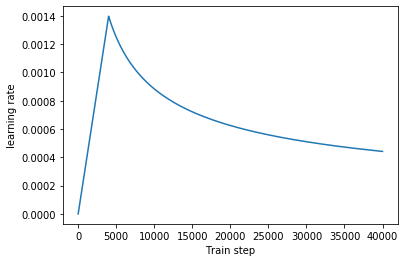

In [51]:
temp_learning_rate_schedule = CustomizedSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000,dtype=tf.float32)))

plt.ylabel("learning rate")
plt.xlabel("Train step")

In [52]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real,pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss_ = loss_object(real,pred)
    
    mask = tf.cast(mask,dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [55]:
def create_masks(inp,tar):
    '''
    Encoder:
        - encoder_padding_mask (self attention of EncoderLayer)
    Decoder:
        - look_ahead_mask (self attention of DecoderLayer)
        - encoder_decoder_padding_mask (encoder-decoder attention of DecoderLayer)
        - decoder_padding_mask (self attention of DecoderLayer)
    '''
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    decoder_padding_mask = create_padding_mask(tar)
    decoder_mask = tf.maximum(decoder_padding_mask,look_ahead_mask)

    #print(encoder_padding_mask.shape)
    #print(encoder_decoder_padding_mask.shape)
    #print(look_ahead_mask.shape)
    #print(decoder_padding_mask.shape)
    #print(decoder_mask.shape)

    return encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask

In [56]:
temp_inp, temp_tar = iter(train_dataset.take(1)).next()

print(temp_inp.shape)
print(temp_tar.shape)
create_masks(temp_inp,temp_tar)

(64, 35)
(64, 37)


(<tf.Tensor: shape=(64, 1, 1, 35), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(64, 1, 37, 37), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.

In [57]:
#6_train_step

train_loss = keras.metrics.Mean(name= 'train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

@tf.function
def train_step(inp,tar):
    tar_inp = tar[:,:-1]
    tar_real = tar[:,1:]

    encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask = create_masks(inp,tar_inp)

    with tf.GradientTape() as tape:
        predictions,_ = transformer(inp,tar_inp,True,encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask)
        loss = loss_function(tar_real,predictions)

    gradients = tape.gradient(loss,transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients,transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real,predictions)

epochs = 20
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch,(inp,tar)) in enumerate(train_dataset):
        train_step(inp,tar)
        if batch%100 ==0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1,batch,train_loss.result(),train_accuracy.result()))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1,train_loss.result(),train_accuracy.result()))
    print('Time take for 1 epoch: {} secs\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 3.9059 Accuracy 0.0000


Epoch 1 Batch 100 Loss 4.2014 Accuracy 0.0114
Epoch 1 Batch 200 Loss 4.0901 Accuracy 0.0191


Epoch 1 Batch 300 Loss 3.9271 Accuracy 0.0222
Epoch 1 Batch 400 Loss 3.7499 Accuracy 0.0288
Epoch 1 Batch 500 Loss 3.6000 Accuracy 0.0349
Epoch 1 Batch 600 Loss 3.4784 Accuracy 0.0422
Epoch 1 Batch 700 Loss 3.3701 Accuracy 0.0493
Epoch 1 Loss 3.3675 Accuracy 0.0494
Time take for 1 epoch: 1178.2931780815125 secs

Epoch 2 Batch 0 Loss 2.6960 Accuracy 0.1057
Epoch 2 Batch 100 Loss 2.5540 Accuracy 0.1037
Epoch 2 Batch 200 Loss 2.5082 Accuracy 0.1082
Epoch 2 Batch 300 Loss 2.4788 Accuracy 0.1125
Epoch 2 Batch 400 Loss 2.4516 Accuracy 0.1162
Epoch 2 Batch 500 Loss 2.4198 Accuracy 0.1193
Epoch 2 Batch 600 Loss 2.3957 Accuracy 0.1222
Epoch 2 Batch 700 Loss 2.3700 Accuracy 0.1245
Epoch 2 Loss 2.3703 Accuracy 0.1245
Time take for 1 epoch: 892.9876217842102 secs

Epoch 3 Batch 0 Loss 2.0519 Accuracy 0.1508
Epoch 3 Batch 100 Loss 2.1611 Accuracy 0.1432
Epoch 3 Batch 200 Loss 2.1644 Accuracy 0.1455
Epoch 3 Batch 300 Loss 2.1578 Accuracy 0.1472
Epoch 3 Batch 400 Loss 2.1543 Accuracy 0.1484
Epoch 3 B

Epoch 19 Batch 300 Loss 0.5416 Accuracy 0.3458
Epoch 19 Batch 400 Loss 0.5482 Accuracy 0.3453
Epoch 19 Batch 500 Loss 0.5536 Accuracy 0.3443
Epoch 19 Batch 600 Loss 0.5593 Accuracy 0.3438
Epoch 19 Batch 700 Loss 0.5626 Accuracy 0.3422
Epoch 19 Loss 0.5627 Accuracy 0.3422
Time take for 1 epoch: 1264.3505566120148 secs

Epoch 20 Batch 0 Loss 0.5701 Accuracy 0.3804
Epoch 20 Batch 100 Loss 0.5067 Accuracy 0.3528
Epoch 20 Batch 200 Loss 0.5195 Accuracy 0.3520
Epoch 20 Batch 300 Loss 0.5229 Accuracy 0.3497
Epoch 20 Batch 400 Loss 0.5286 Accuracy 0.3483
Epoch 20 Batch 500 Loss 0.5333 Accuracy 0.3478
Epoch 20 Batch 600 Loss 0.5392 Accuracy 0.3467
Epoch 20 Batch 700 Loss 0.5445 Accuracy 0.3464
Epoch 20 Loss 0.5445 Accuracy 0.3464
Time take for 1 epoch: 1284.178857088089 secs



In [70]:
'''
7.1 evaluate
eg: A B C D -> E F G H.
Train: A B C D, E F G -> F G H
Eval:  A B C D -> E
       A B C D, E -> F
       A B C D, E F -> G
       A B C D, E F G -> H
'''

def evaluate(inp_sentence):
    input_id_sentence = [pt_tokenizer.vocab_size]+ pt_tokenizer.encode(inp_sentence) + [pt_tokenizer.vocab_size + 1]

    encoder_input = tf.expand_dims(input_id_sentence,0)  #shape:(1,input_sentence_length)

    decoder_input = tf.expand_dims([en_tokenizer.vocab_size],0)

    for i in range(max_length):
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask = create_masks(encoder_input,decoder_input)
        #predictions.shape=(batch_size, output_target_len,target_vocab_size)
        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask
        )

        predictions = predictions[:,-1,:]   #shape:(batch_size, target_vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions,axis=-1),tf.int32)

        if tf.equal(predicted_id, en_tokenizer.vocab_size +1):
            return tf.squeeze(decoder_input,axis=0),attention_weights

        decoder_input = tf.concat([decoder_input,[predicted_id]],axis = -1)
    return  tf.squeeze(decoder_input,axis = 0), attention_weights

In [71]:
#7.2 visualize

def plot_encoder_decoder_attention(attention,input_sentence,result,layer_num):
    fig = plt.figure(figsize=(16,8))
    input_id_sentence = pt_tokenizer.encode(input_sentence)

    #attention.shape = (num_heads,tar_len,input_len)
    attention = tf.squeeze(attention[layer_num],axis = 0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2,4,head+1)

        ax.matshow(attention[head][:-1,:])
        fontdict = {'fontsize':10}

        ax.set_xticks(range(len(input_id_sentence) +2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result) -1.5,-0.5)
        ax.set_xticklabels(['<start>']+[pt_tokenizer.decode([i]) for i in input_id_sentence]+['<end>'],fontdict = fontdict, rotation = 90)
        ax.set_yticklabels([en_tokenizer.decode([i])for i in result if i < en_tokenizer.vocab_size], fontdict = fontdict)
        ax.set_xlabel('Head{}'.format(head+1))
    plt.tight_layout()
    plt.show()

In [72]:
def translate(input_sentence, layer_name = ''):
    result, attention_weights = evaluate(input_sentence)

    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size]
    )

    print('Input: {}'.format(input_sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if layer_name:
        plot_encoder_decoder_attention(attention_weights,input_sentence,result,layer_name)

In [73]:
translate('está frio aqui.')

Input: está frio aqui.
Predicted translation: it 's cold-cold-standing here .


Input: qual o seu nome?
Predicted translation: what about his name ?


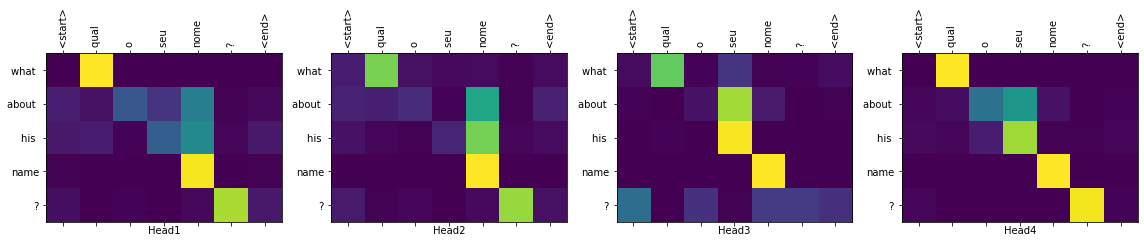

In [74]:
translate('qual o seu nome?',layer_name='decoder_layer4_att2')

Input: você sabe que meu cachorro tem seu próprio filho agora?
Predicted translation: do you know what my dogs is going to cry you now do ?


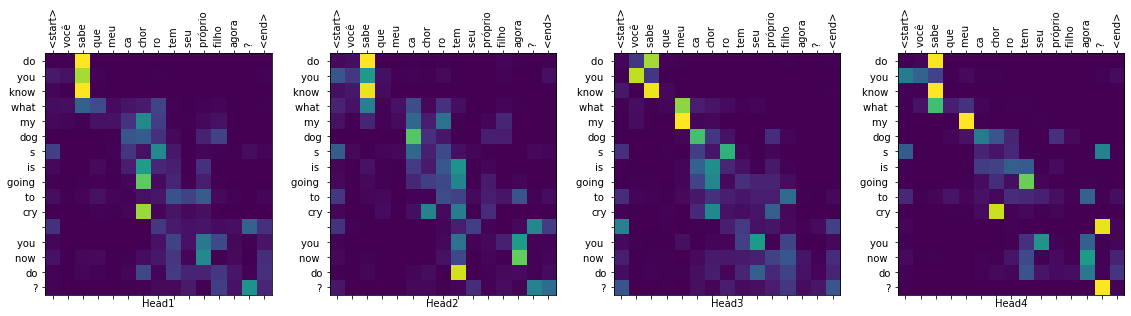

In [75]:
translate('você sabe que meu cachorro tem seu próprio filho agora?',layer_name='decoder_layer4_att2')